<a href="https://colab.research.google.com/github/Thisumi1/telco-churn-prediction/blob/main/notebooks/Task02%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TELCO CUSTOMER CHURN PREDICTION
# Task 2: Data Preprocessing & Model Development

**Module:** CM2604 Machine Learning  
**Student Name:** Thisumi Ranasinghe   
**Student ID:** 20240854/2425435  
**Date:** December 2024  
**GitHub:** https://github.com/Thisumi1/telco-churn-prediction

---

## Objective
Develop and evaluate two machine learning models to predict customer churn:
1. **Decision Tree Classifier** - Interpretable, rule-based model
2. **Neural Network (MLPClassifier)** - Captures non-linear patterns

Both models are optimized using GridSearchCV and evaluated with comprehensive metrics including train-test comparison for overfitting detection.

---

## 1. Setup & Library Imports

In [ ]:
# Install imbalanced-learn if needed
# !pip install imbalanced-learn

In [ ]:
# ============================================================
# IMPORT LIBRARIES
# ============================================================

# Core Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# Preprocessing & Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, classification_report)

# Save Models
import joblib

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✅ All libraries imported successfully!")
print(f"\nLibrary Versions:")
print(f"  • pandas: {pd.__version__}")
print(f"  • numpy: {np.__version__}")
print(f"  • scikit-learn: {__import__('sklearn').__version__}")

✅ All libraries imported successfully!

Library Versions:
  • pandas: 2.2.2
  • numpy: 2.0.2
  • scikit-learn: 1.6.1


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set working directory in Drive
project_path = '/content/drive/MyDrive/MLCoursework/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ============================================================
# CREATE OUTPUT DIRECTORIES
# ============================================================

os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print("✅ Output directories created: figures/, models/, reports/")

✅ Output directories created: figures/, models/, reports/


---
## 2. Load Dataset

In [ ]:
# ============================================================
# LOAD DATA
# ============================================================

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/MLCoursework/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("="*60)
print("DATASET LOADED SUCCESSFULLY")
print("="*60)
print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget Variable Distribution:")
print(df['Churn'].value_counts())
print(f"\nClass Imbalance: {df['Churn'].value_counts(normalize=True).round(3).to_dict()}")

DATASET LOADED SUCCESSFULLY

Shape: 7043 rows × 21 columns

Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Target Variable Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Class Imbalance: {'No': 0.735, 'Yes': 0.265}


In [ ]:
# Quick data overview
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---
## 3. Data Preprocessing

### Preprocessing Pipeline:
1. Remove identifier column (customerID)
2. Handle data type issues (TotalCharges)
3. Impute missing values
4. Binary encoding for binary categorical variables
5. One-hot encoding for multi-category variables
6. Feature scaling (StandardScaler)
7. Train-test split (80-20, stratified)
8. SMOTE for class balancing (training data only)

In [ ]:
# ============================================================
# STEP 1: REMOVE IDENTIFIER COLUMN
# ============================================================

# customerID provides no predictive value - it's just a unique identifier
df = df.drop('customerID', axis=1)

print("✅ Step 1: Removed 'customerID' column")
print(f"   Remaining columns: {df.shape[1]}")

✅ Step 1: Removed 'customerID' column
   Remaining columns: 20


In [ ]:
# ============================================================
# STEP 2: HANDLE DATA TYPE ISSUES
# ============================================================

# TotalCharges is stored as object (string) due to whitespace values
print(f"TotalCharges current dtype: {df['TotalCharges'].dtype}")

# Convert to numeric (whitespace becomes NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print(f"TotalCharges new dtype: {df['TotalCharges'].dtype}")
print(f"\n✅ Step 2: Converted TotalCharges to numeric")

TotalCharges current dtype: object
TotalCharges new dtype: float64

✅ Step 2: Converted TotalCharges to numeric


In [ ]:
# ============================================================
# STEP 3: IMPUTE MISSING VALUES
# ============================================================

# Check missing values
missing_count = df['TotalCharges'].isna().sum()
print(f"Missing values in TotalCharges: {missing_count}")

# These are new customers (tenure = 0) - their TotalCharges should equal MonthlyCharges
print(f"\nVerifying: These customers have tenure = 0:")
print(df[df['TotalCharges'].isna()][['tenure', 'MonthlyCharges']].head())

# Impute with MonthlyCharges (business logic: new customer's first payment)
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'])

print(f"\n✅ Step 3: Imputed {missing_count} missing values with MonthlyCharges")
print(f"   Remaining missing values: {df.isnull().sum().sum()}")

Missing values in TotalCharges: 11

Verifying: These customers have tenure = 0:
      tenure  MonthlyCharges
488        0           52.55
753        0           20.25
936        0           80.85
1082       0           25.75
1340       0           56.05

✅ Step 3: Imputed 11 missing values with MonthlyCharges
   Remaining missing values: 0


In [ ]:
# ============================================================
# STEP 4: BINARY ENCODING
# ============================================================

# Identify binary columns (Yes/No or Male/Female)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

print("Binary columns to encode:")
for col in binary_cols:
    print(f"  • {col}: {df[col].unique()}")

# Apply binary encoding
binary_map = {'Yes': 1, 'No': 0, 'Male': 0, 'Female': 1}
for col in binary_cols:
    df[col] = df[col].map(binary_map)

print(f"\n✅ Step 4: Binary encoded {len(binary_cols)} columns")

Binary columns to encode:
  • gender: ['Female' 'Male']
  • Partner: ['Yes' 'No']
  • Dependents: ['No' 'Yes']
  • PhoneService: ['No' 'Yes']
  • PaperlessBilling: ['Yes' 'No']
  • Churn: ['No' 'Yes']

✅ Step 4: Binary encoded 6 columns


In [ ]:
# ============================================================
# STEP 5: ONE-HOT ENCODING
# ============================================================

# Identify multi-category columns (more than 2 unique values)
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

print("Multi-category columns to one-hot encode:")
for col in multi_cat_cols:
    print(f"  • {col}: {df[col].nunique()} unique values")

# Apply one-hot encoding (drop_first=True to avoid multicollinearity)
df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

print(f"\n✅ Step 5: One-hot encoded {len(multi_cat_cols)} columns")
print(f"   New shape: {df.shape}")

Multi-category columns to one-hot encode:
  • MultipleLines: 3 unique values
  • InternetService: 3 unique values
  • OnlineSecurity: 3 unique values
  • OnlineBackup: 3 unique values
  • DeviceProtection: 3 unique values
  • TechSupport: 3 unique values
  • StreamingTV: 3 unique values
  • StreamingMovies: 3 unique values
  • Contract: 3 unique values
  • PaymentMethod: 4 unique values

✅ Step 5: One-hot encoded 10 columns
   New shape: (7043, 31)


In [ ]:
# ============================================================
# STEP 6: SEPARATE FEATURES AND TARGET
# ============================================================

X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(list(X.columns))

Features (X): (7043, 30)
Target (y): (7043,)

Feature columns (30):
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [ ]:
# ============================================================
# STEP 7: FEATURE SCALING
# ============================================================

# Identify numerical columns that need scaling
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("Before scaling:")
print(X[numerical_cols].describe().round(2))

# Apply StandardScaler
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

print("\nAfter scaling (mean≈0, std≈1):")
print(X[numerical_cols].describe().round(2))

# Save scaler for future use
joblib.dump(scaler, '/content/drive/MyDrive/MLCoursework/models/scaler.joblib')
print("\n✅ Step 7: Numerical features scaled and scaler saved")

Before scaling:
        tenure  MonthlyCharges  TotalCharges
count  7043.00         7043.00       7043.00
mean     32.37           64.76       2279.80
std      24.56           30.09       2266.73
min       0.00           18.25         18.80
25%       9.00           35.50        398.55
50%      29.00           70.35       1394.55
75%      55.00           89.85       3786.60
max      72.00          118.75       8684.80

After scaling (mean≈0, std≈1):
        tenure  MonthlyCharges  TotalCharges
count  7043.00         7043.00       7043.00
mean     -0.00           -0.00         -0.00
std       1.00            1.00          1.00
min      -1.32           -1.55         -1.00
25%      -0.95           -0.97         -0.83
50%      -0.14            0.19         -0.39
75%       0.92            0.83          0.66
max       1.61            1.79          2.83

✅ Step 7: Numerical features scaled and scaler saved


In [ ]:
# ============================================================
# STEP 8: TRAIN-TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,     # Reproducibility
    stratify=y           # Maintain class proportions
)

print("✅ Step 8: Train-Test Split (80-20, stratified)")
print(f"\n   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"\n   Training class distribution:")
print(f"     No Churn: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"     Churn: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

✅ Step 8: Train-Test Split (80-20, stratified)

   Training set: 5634 samples
   Test set: 1409 samples

   Training class distribution:
     No Churn: 4139 (73.5%)
     Churn: 1495 (26.5%)


In [ ]:
# ============================================================
# STEP 9: SMOTE - SYNTHETIC MINORITY OVERSAMPLING
# ============================================================

print("="*60)
print("APPLYING SMOTE FOR CLASS BALANCING")
print("="*60)

print("\n📊 BEFORE SMOTE:")
print(f"   Training samples: {len(X_train)}")
print(f"   No Churn (0): {(y_train == 0).sum()}")
print(f"   Churn (1): {(y_train == 1).sum()}")
print(f"   Ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f} : 1")

# Apply SMOTE to training data ONLY (never to test data!)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\n📊 AFTER SMOTE:")
print(f"   Training samples: {len(X_train_balanced)}")
print(f"   No Churn (0): {(y_train_balanced == 0).sum()}")
print(f"   Churn (1): {(y_train_balanced == 1).sum()}")
print(f"   Ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.2f} : 1")

print(f"\n✅ Step 9: SMOTE applied - created {len(X_train_balanced) - len(X_train)} synthetic samples")

APPLYING SMOTE FOR CLASS BALANCING

📊 BEFORE SMOTE:
   Training samples: 5634
   No Churn (0): 4139
   Churn (1): 1495
   Ratio: 2.77 : 1

📊 AFTER SMOTE:
   Training samples: 8278
   No Churn (0): 4139
   Churn (1): 4139
   Ratio: 1.00 : 1

✅ Step 9: SMOTE applied - created 2644 synthetic samples


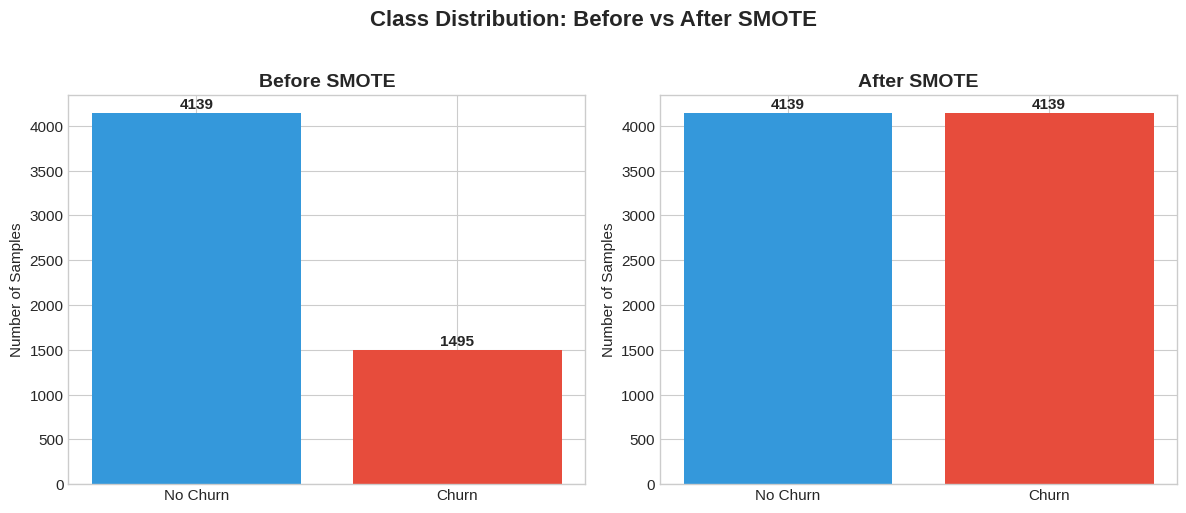


✅ Figure saved: figures/11_smote_comparison.png


In [ ]:
# ============================================================
# VISUALIZE SMOTE EFFECT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
colors = ['#3498db', '#e74c3c']
axes[0].bar(['No Churn', 'Churn'],
            [(y_train == 0).sum(), (y_train == 1).sum()],
            color=colors)
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
for i, v in enumerate([(y_train == 0).sum(), (y_train == 1).sum()]):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# After SMOTE
axes[1].bar(['No Churn', 'Churn'],
            [(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()],
            color=colors)
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Samples')
for i, v in enumerate([(y_train_balanced == 0).sum(), (y_train_balanced == 1).sum()]):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.suptitle('Class Distribution: Before vs After SMOTE', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/1_smote_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Figure saved: figures/11_smote_comparison.png")

---
## 4. Model 1: Decision Tree Classifier

Decision Tree was chosen for:
- **Interpretability**: Easy to understand and explain decisions
- **Feature Importance**: Identifies which features matter most
- **No scaling required**: Works with raw feature values (though we scaled for consistency)
- **Handles non-linear relationships**: Through hierarchical splitting

In [ ]:
# ============================================================
# DECISION TREE - BASELINE MODEL
# ============================================================

print("="*60)
print("DECISION TREE CLASSIFIER")
print("="*60)

# Train baseline model (default parameters)
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_balanced, y_train_balanced)

# Predictions
dt_baseline_train_pred = dt_baseline.predict(X_train_balanced)
dt_baseline_test_pred = dt_baseline.predict(X_test)

print("\n📊 BASELINE MODEL PERFORMANCE:")
print(f"   Training Accuracy: {accuracy_score(y_train_balanced, dt_baseline_train_pred)*100:.2f}%")
print(f"   Test Accuracy: {accuracy_score(y_test, dt_baseline_test_pred)*100:.2f}%")
print(f"   Gap: {(accuracy_score(y_train_balanced, dt_baseline_train_pred) - accuracy_score(y_test, dt_baseline_test_pred))*100:.2f}%")
print("\n   ⚠️  Large gap indicates overfitting - needs hyperparameter tuning!")

DECISION TREE CLASSIFIER

📊 BASELINE MODEL PERFORMANCE:
   Training Accuracy: 99.87%
   Test Accuracy: 72.46%
   Gap: 27.40%

   ⚠️  Large gap indicates overfitting - needs hyperparameter tuning!


In [ ]:
# ============================================================
# DECISION TREE - HYPERPARAMETER TUNING (GridSearchCV)
# ============================================================

print("\n🔧 HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("-"*60)

# Define parameter grid
dt_param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [20, 30, 50],
    'min_samples_leaf': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

print(f"Parameter grid: {dt_param_grid}")
print(f"Total combinations: {np.prod([len(v) for v in dt_param_grid.values()])}")

# Perform GridSearchCV
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='f1',        # Optimize for F1-score (better for imbalanced data)
    n_jobs=-1,           # Use all CPU cores
    verbose=1
)

print("\nTraining... (this may take a minute)")
dt_grid.fit(X_train_balanced, y_train_balanced)

print(f"\n✅ Best Parameters: {dt_grid.best_params_}")
print(f"   Best CV F1-Score: {dt_grid.best_score_:.4f}")


🔧 HYPERPARAMETER TUNING WITH GRIDSEARCHCV
------------------------------------------------------------
Parameter grid: {'max_depth': [3, 4, 5, 6], 'min_samples_split': [20, 30, 50], 'min_samples_leaf': [10, 20, 30], 'criterion': ['gini', 'entropy']}
Total combinations: 72

Training... (this may take a minute)
Fitting 5 folds for each of 72 candidates, totalling 360 fits

✅ Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 30}
   Best CV F1-Score: 0.7811


In [ ]:
# ============================================================
# DECISION TREE - BEST MODEL EVALUATION
# ============================================================

# Get best model
dt_best = dt_grid.best_estimator_

# Predictions on BOTH training and test sets
dt_train_pred = dt_best.predict(X_train_balanced)
dt_test_pred = dt_best.predict(X_test)
dt_train_proba = dt_best.predict_proba(X_train_balanced)[:, 1]
dt_test_proba = dt_best.predict_proba(X_test)[:, 1]

# Calculate all metrics for BOTH sets
dt_metrics = {
    'Training': {
        'Accuracy': accuracy_score(y_train_balanced, dt_train_pred),
        'Precision': precision_score(y_train_balanced, dt_train_pred),
        'Recall': recall_score(y_train_balanced, dt_train_pred),
        'F1-Score': f1_score(y_train_balanced, dt_train_pred),
        'ROC-AUC': roc_auc_score(y_train_balanced, dt_train_proba)
    },
    'Test': {
        'Accuracy': accuracy_score(y_test, dt_test_pred),
        'Precision': precision_score(y_test, dt_test_pred),
        'Recall': recall_score(y_test, dt_test_pred),
        'F1-Score': f1_score(y_test, dt_test_pred),
        'ROC-AUC': roc_auc_score(y_test, dt_test_proba)
    }
}

print("\n" + "="*60)
print("DECISION TREE - OPTIMIZED MODEL RESULTS")
print("="*60)

# Display comparison table
print("\n📊 TRAIN VS TEST COMPARISON:")
print("-"*60)
print(f"{'Metric':<15} {'Training':>12} {'Test':>12} {'Difference':>12}")
print("-"*60)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    train_val = dt_metrics['Training'][metric]
    test_val = dt_metrics['Test'][metric]
    diff = train_val - test_val
    print(f"{metric:<15} {train_val*100:>11.2f}% {test_val*100:>11.2f}% {diff*100:>+11.2f}%")
print("-"*60)

# Overfitting check
acc_gap = dt_metrics['Training']['Accuracy'] - dt_metrics['Test']['Accuracy']
print("\n🔍 OVERFITTING CHECK:")
if acc_gap > 0.10:
    print(f"   ⚠️  WARNING: Accuracy gap of {acc_gap*100:.2f}% indicates SEVERE overfitting")
elif acc_gap > 0.05:
    print(f"   ⚡ CAUTION: Accuracy gap of {acc_gap*100:.2f}% indicates SLIGHT overfitting")
else:
    print(f"   ✅ GOOD: Accuracy gap of {acc_gap*100:.2f}% - model generalizes well!")


DECISION TREE - OPTIMIZED MODEL RESULTS

📊 TRAIN VS TEST COMPARISON:
------------------------------------------------------------
Metric              Training         Test   Difference
------------------------------------------------------------
Accuracy              78.46%       73.95%       +4.51%
Precision             75.66%       50.60%      +25.06%
Recall                83.91%       78.88%       +5.03%
F1-Score              79.57%       61.65%      +17.92%
ROC-AUC               86.36%       82.63%       +3.73%
------------------------------------------------------------

🔍 OVERFITTING CHECK:
   ✅ GOOD: Accuracy gap of 4.51% - model generalizes well!


In [ ]:
# ============================================================
# DECISION TREE - CLASSIFICATION REPORT
# ============================================================

print("\n📋 CLASSIFICATION REPORT (Test Set):")
print("="*60)
print(classification_report(y_test, dt_test_pred, target_names=['No Churn', 'Churn']))


📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

    No Churn       0.90      0.72      0.80      1035
       Churn       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



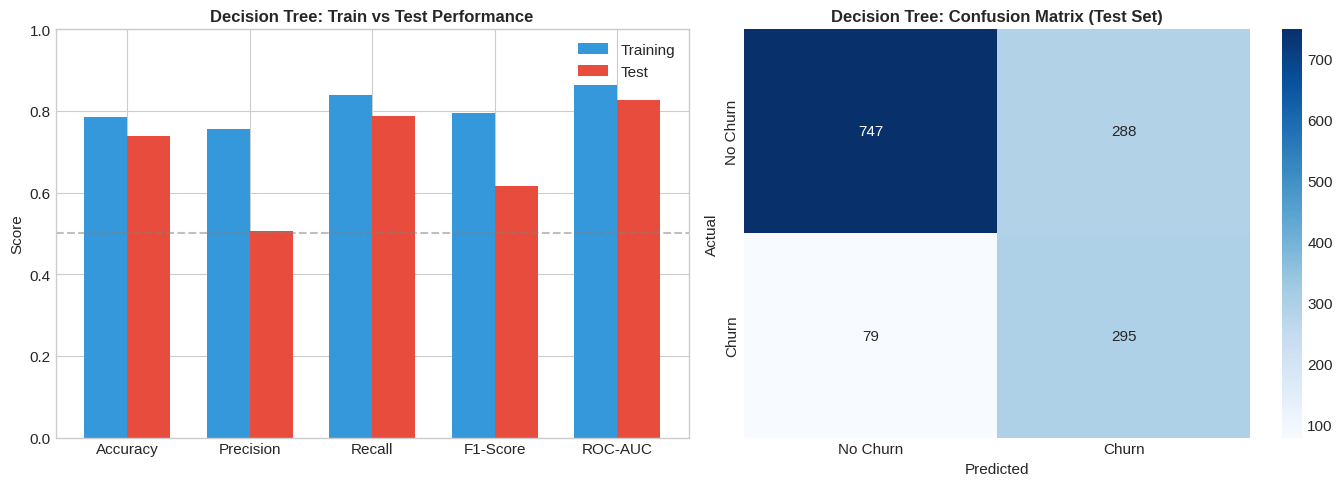

✅ Figure saved: figures/12_decision_tree_evaluation.png


In [ ]:
# ============================================================
# DECISION TREE - VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Metrics Bar Chart
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_list))
width = 0.35

train_vals = [dt_metrics['Training'][m] for m in metrics_list]
test_vals = [dt_metrics['Test'][m] for m in metrics_list]

bars1 = axes[0].bar(x - width/2, train_vals, width, label='Training', color='#3498db')
bars2 = axes[0].bar(x + width/2, test_vals, width, label='Test', color='#e74c3c')

axes[0].set_ylabel('Score')
axes[0].set_title('Decision Tree: Train vs Test Performance', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_list)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Confusion Matrix
cm = confusion_matrix(y_test, dt_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Decision Tree: Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/12_decision_tree_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/12_decision_tree_evaluation.png")

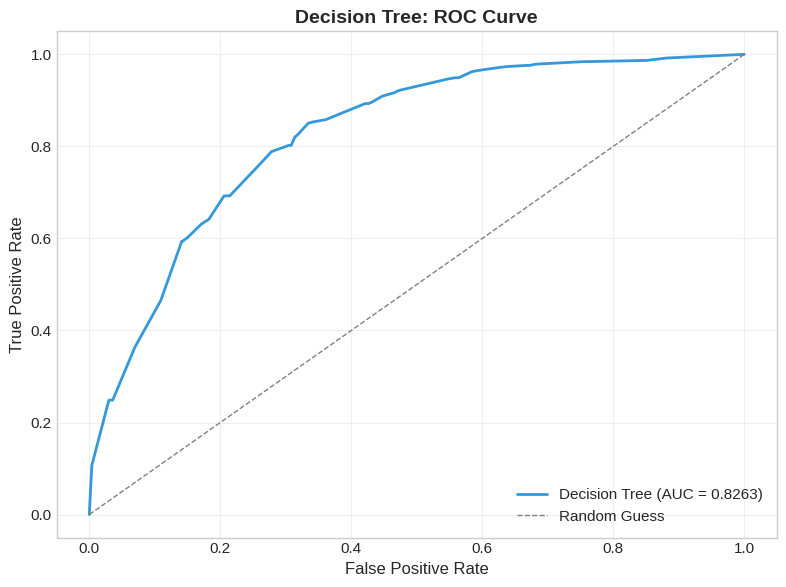

✅ Figure saved: figures/13_dt_roc_curve.png


In [ ]:
# ============================================================
# DECISION TREE - ROC CURVE
# ============================================================

plt.figure(figsize=(8, 6))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, dt_test_proba)
roc_auc = roc_auc_score(y_test, dt_test_proba)

# Plot
plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'Decision Tree (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Decision Tree: ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/13_dt_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/13_dt_roc_curve.png")

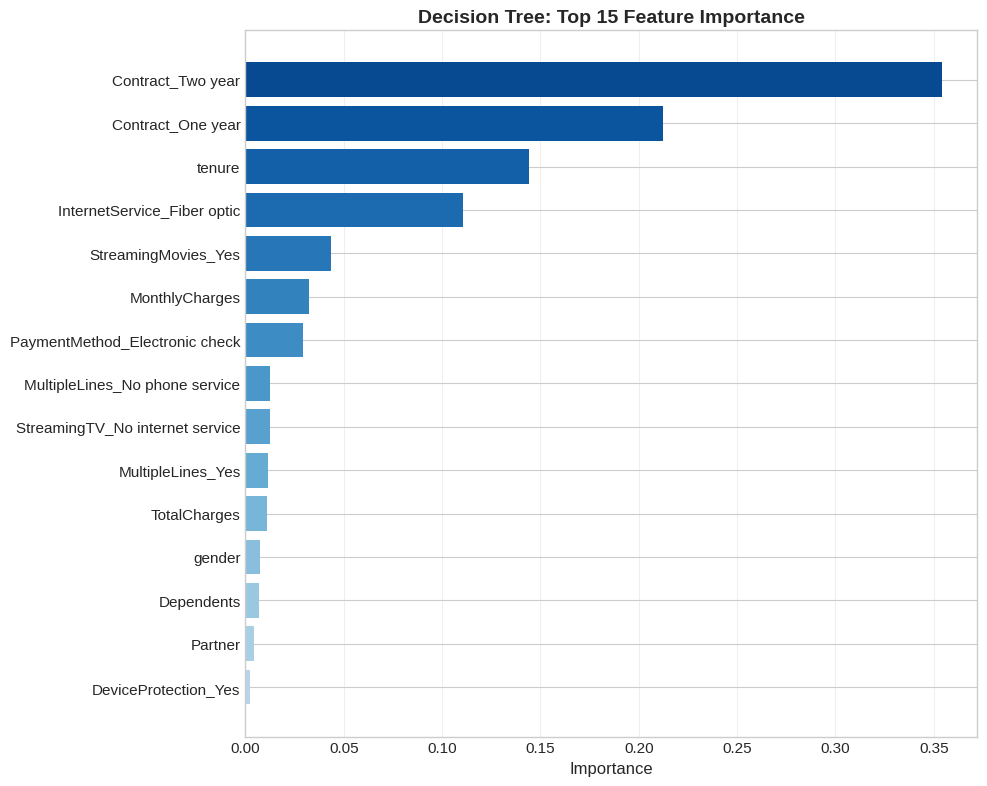

✅ Figure saved: figures/14_dt_feature_importance.png

📊 TOP 10 MOST IMPORTANT FEATURES:
----------------------------------------
  Contract_Two year                   0.3542
  Contract_One year                   0.2122
  tenure                              0.1444
  InternetService_Fiber optic         0.1108
  StreamingMovies_Yes                 0.0435
  MonthlyCharges                      0.0325
  PaymentMethod_Electronic check      0.0295
  MultipleLines_No phone service      0.0127
  StreamingTV_No internet service     0.0123
  MultipleLines_Yes                   0.0115


In [ ]:
# ============================================================
# DECISION TREE - FEATURE IMPORTANCE
# ============================================================

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_best.feature_importances_
}).sort_values('Importance', ascending=True)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.tail(15)

colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(top_features)))
plt.barh(top_features['Feature'], top_features['Importance'], color=colors)
plt.xlabel('Importance', fontsize=12)
plt.title('Decision Tree: Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/14_dt_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/14_dt_feature_importance.png")

# Display top 10 features
print("\n📊 TOP 10 MOST IMPORTANT FEATURES:")
print("-"*40)
for i, row in feature_importance.tail(10).iloc[::-1].iterrows():
    print(f"  {row['Feature']:<35} {row['Importance']:.4f}")

In [ ]:
# ============================================================
# SAVE DECISION TREE MODEL
# ============================================================

joblib.dump(dt_best, '/content/drive/MyDrive/MLCoursework/models/decision_tree_model.joblib')
print("✅ Decision Tree model saved: models/decision_tree_model.joblib")

✅ Decision Tree model saved: models/decision_tree_model.joblib


---
## 5. Model 2: Neural Network (MLPClassifier)

Multi-Layer Perceptron (MLP) was chosen for:
- **Non-linear patterns**: Can capture complex relationships through hidden layers
- **Universal approximator**: Can learn any continuous function
- **Complementary to Decision Tree**: Different learning approach for comparison

In [ ]:
# ============================================================
# NEURAL NETWORK - BASELINE MODEL
# ============================================================

print("="*60)
print("NEURAL NETWORK (MLPClassifier)")
print("="*60)

# Train baseline model
nn_baseline = MLPClassifier(max_iter=500, random_state=42)
nn_baseline.fit(X_train_balanced, y_train_balanced)

# Predictions
nn_baseline_train_pred = nn_baseline.predict(X_train_balanced)
nn_baseline_test_pred = nn_baseline.predict(X_test)

print("\n📊 BASELINE MODEL PERFORMANCE:")
print(f"   Training Accuracy: {accuracy_score(y_train_balanced, nn_baseline_train_pred)*100:.2f}%")
print(f"   Test Accuracy: {accuracy_score(y_test, nn_baseline_test_pred)*100:.2f}%")
print(f"   Gap: {(accuracy_score(y_train_balanced, nn_baseline_train_pred) - accuracy_score(y_test, nn_baseline_test_pred))*100:.2f}%")

NEURAL NETWORK (MLPClassifier)

📊 BASELINE MODEL PERFORMANCE:
   Training Accuracy: 87.33%
   Test Accuracy: 76.44%
   Gap: 10.89%


In [ ]:
# ============================================================
# NEURAL NETWORK - HYPERPARAMETER TUNING (GridSearchCV)
# ============================================================

print("\n🔧 HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("-"*60)

# Define parameter grid
nn_param_grid = {
    'hidden_layer_sizes': [(32,), (50,), (32, 16)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.01, 0.1, 0.5],
    'learning_rate': ['adaptive']
}

print(f"Parameter grid: {nn_param_grid}")
print(f"Total combinations: {np.prod([len(v) for v in nn_param_grid.values()])}")

# Perform GridSearchCV
nn_grid = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42, early_stopping=True),
    nn_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nTraining... (this may take a few minutes)")
nn_grid.fit(X_train_balanced, y_train_balanced)

print(f"\n✅ Best Parameters: {nn_grid.best_params_}")
print(f"   Best CV F1-Score: {nn_grid.best_score_:.4f}")


🔧 HYPERPARAMETER TUNING WITH GRIDSEARCHCV
------------------------------------------------------------
Parameter grid: {'hidden_layer_sizes': [(32,), (50,), (32, 16)], 'activation': ['relu', 'tanh'], 'alpha': [0.01, 0.1, 0.5], 'learning_rate': ['adaptive']}
Total combinations: 18

Training... (this may take a few minutes)
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (32,), 'learning_rate': 'adaptive'}
   Best CV F1-Score: 0.7918


In [ ]:
# ============================================================
# NEURAL NETWORK - BEST MODEL EVALUATION
# ============================================================

# Get best model
nn_best = nn_grid.best_estimator_

# Predictions on BOTH training and test sets
nn_train_pred = nn_best.predict(X_train_balanced)
nn_test_pred = nn_best.predict(X_test)
nn_train_proba = nn_best.predict_proba(X_train_balanced)[:, 1]
nn_test_proba = nn_best.predict_proba(X_test)[:, 1]

# Calculate all metrics for BOTH sets
nn_metrics = {
    'Training': {
        'Accuracy': accuracy_score(y_train_balanced, nn_train_pred),
        'Precision': precision_score(y_train_balanced, nn_train_pred),
        'Recall': recall_score(y_train_balanced, nn_train_pred),
        'F1-Score': f1_score(y_train_balanced, nn_train_pred),
        'ROC-AUC': roc_auc_score(y_train_balanced, nn_train_proba)
    },
    'Test': {
        'Accuracy': accuracy_score(y_test, nn_test_pred),
        'Precision': precision_score(y_test, nn_test_pred),
        'Recall': recall_score(y_test, nn_test_pred),
        'F1-Score': f1_score(y_test, nn_test_pred),
        'ROC-AUC': roc_auc_score(y_test, nn_test_proba)
    }
}

print("\n" + "="*60)
print("NEURAL NETWORK - OPTIMIZED MODEL RESULTS")
print("="*60)

# Display comparison table
print("\n📊 TRAIN VS TEST COMPARISON:")
print("-"*60)
print(f"{'Metric':<15} {'Training':>12} {'Test':>12} {'Difference':>12}")
print("-"*60)
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    train_val = nn_metrics['Training'][metric]
    test_val = nn_metrics['Test'][metric]
    diff = train_val - test_val
    print(f"{metric:<15} {train_val*100:>11.2f}% {test_val*100:>11.2f}% {diff*100:>+11.2f}%")
print("-"*60)

# Overfitting check
acc_gap = nn_metrics['Training']['Accuracy'] - nn_metrics['Test']['Accuracy']
print("\n🔍 OVERFITTING CHECK:")
if acc_gap > 0.10:
    print(f"   ⚠️  WARNING: Accuracy gap of {acc_gap*100:.2f}% indicates SEVERE overfitting")
elif acc_gap > 0.05:
    print(f"   ⚡ CAUTION: Accuracy gap of {acc_gap*100:.2f}% indicates SLIGHT overfitting")
else:
    print(f"   ✅ GOOD: Accuracy gap of {acc_gap*100:.2f}% - model generalizes well!")


NEURAL NETWORK - OPTIMIZED MODEL RESULTS

📊 TRAIN VS TEST COMPARISON:
------------------------------------------------------------
Metric              Training         Test   Difference
------------------------------------------------------------
Accuracy              77.86%       72.68%       +5.18%
Precision             76.25%       49.04%      +27.22%
Recall                80.91%       74.87%       +6.05%
F1-Score              78.51%       59.26%      +19.25%
ROC-AUC               85.82%       82.69%       +3.13%
------------------------------------------------------------

🔍 OVERFITTING CHECK:
   ⚡ CAUTION: Accuracy gap of 5.18% indicates SLIGHT overfitting


In [ ]:
# ============================================================
# NEURAL NETWORK - CLASSIFICATION REPORT
# ============================================================

print("\n📋 CLASSIFICATION REPORT (Test Set):")
print("="*60)
print(classification_report(y_test, nn_test_pred, target_names=['No Churn', 'Churn']))


📋 CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

    No Churn       0.89      0.72      0.79      1035
       Churn       0.49      0.75      0.59       374

    accuracy                           0.73      1409
   macro avg       0.69      0.73      0.69      1409
weighted avg       0.78      0.73      0.74      1409



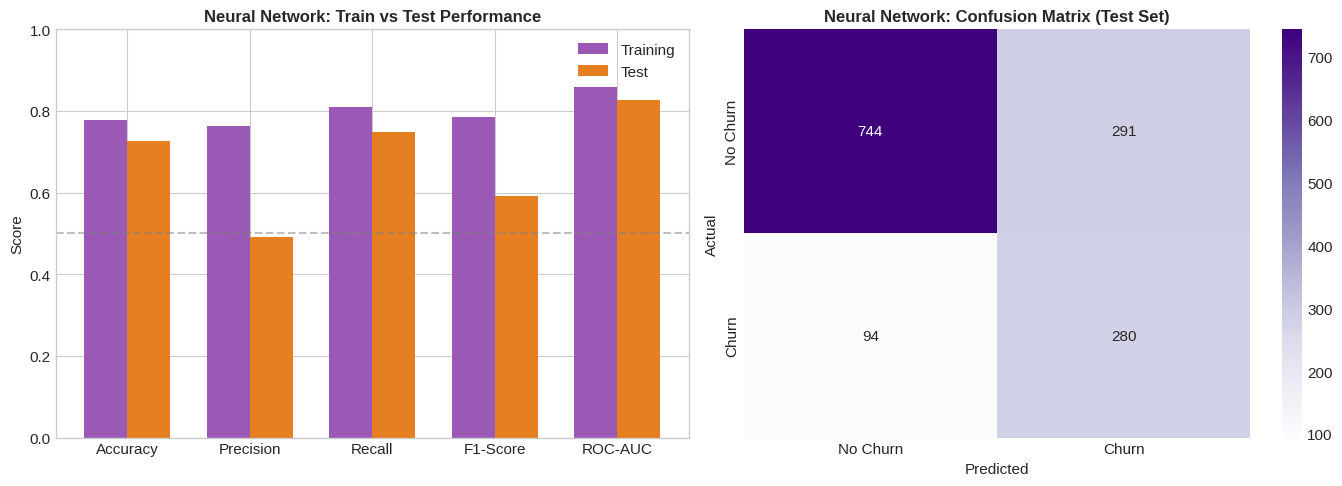

✅ Figure saved: figures/15_neural_network_evaluation.png


In [ ]:
# ============================================================
# NEURAL NETWORK - VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Metrics Bar Chart
train_vals = [nn_metrics['Training'][m] for m in metrics_list]
test_vals = [nn_metrics['Test'][m] for m in metrics_list]

bars1 = axes[0].bar(x - width/2, train_vals, width, label='Training', color='#9b59b6')
bars2 = axes[0].bar(x + width/2, test_vals, width, label='Test', color='#e67e22')

axes[0].set_ylabel('Score')
axes[0].set_title('Neural Network: Train vs Test Performance', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_list)
axes[0].legend()
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Plot 2: Confusion Matrix
cm_nn = confusion_matrix(y_test, nn_test_pred)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Neural Network: Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/15_neural_network_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/15_neural_network_evaluation.png")

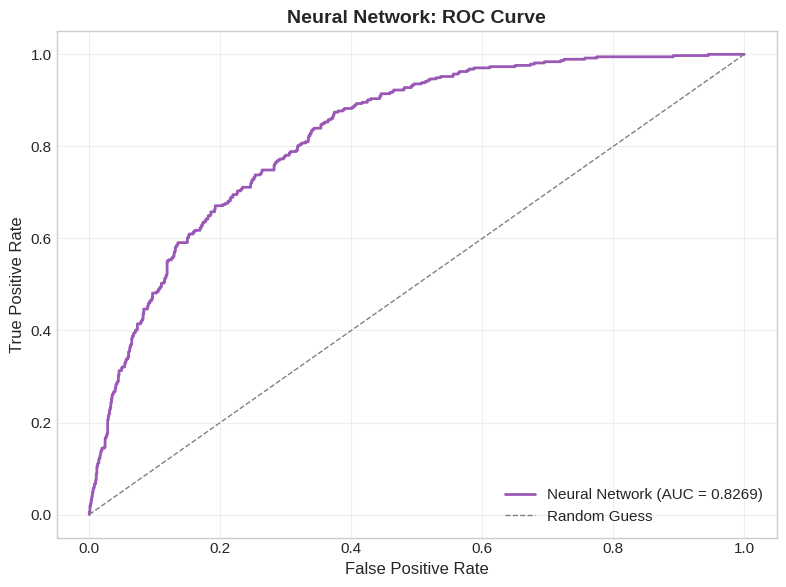

✅ Figure saved: figures/16_nn_roc_curve.png


In [ ]:
# ============================================================
# NEURAL NETWORK - ROC CURVE
# ============================================================

plt.figure(figsize=(8, 6))

# Calculate ROC curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_test_proba)
roc_auc_nn = roc_auc_score(y_test, nn_test_proba)

# Plot
plt.plot(fpr_nn, tpr_nn, color='#9b59b6', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Neural Network: ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/16_nn_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/16_nn_roc_curve.png")

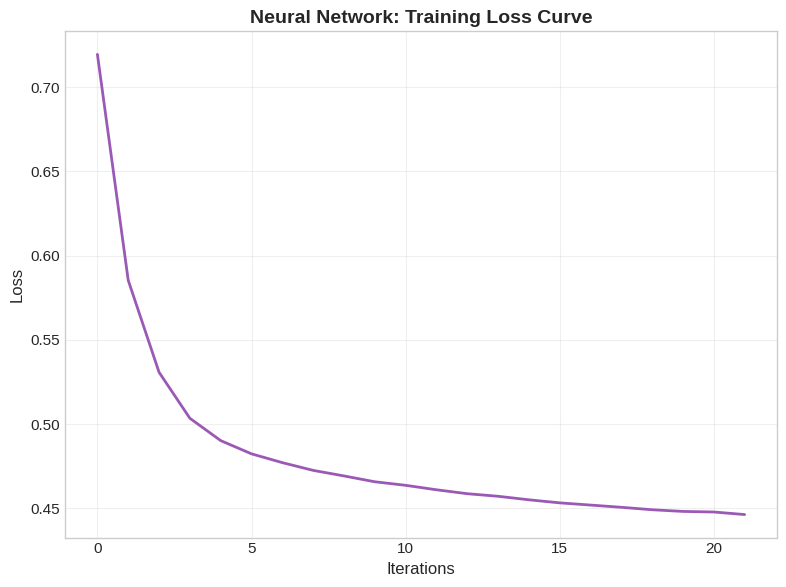

✅ Figure saved: figures/17_nn_loss_curve.png


In [ ]:
# ============================================================
# NEURAL NETWORK - LOSS CURVE
# ============================================================

plt.figure(figsize=(8, 6))

plt.plot(nn_best.loss_curve_, color='#9b59b6', lw=2)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Neural Network: Training Loss Curve', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/17_nn_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/17_nn_loss_curve.png")

In [ ]:
# ============================================================
# SAVE NEURAL NETWORK MODEL
# ============================================================

joblib.dump(nn_best, '/content/drive/MyDrive/MLCoursework/models/neural_network_model.joblib')
print("✅ Neural Network model saved: models/neural_network_model.joblib")

✅ Neural Network model saved: models/neural_network_model.joblib


---
## 6. Model Comparison

Comprehensive comparison of both models on the test set.

In [ ]:
# ============================================================
# MODEL COMPARISON TABLE
# ============================================================

print("="*70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("="*70)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Churn)', 'Recall (Churn)', 'F1-Score (Churn)', 'ROC-AUC'],
    'Decision Tree': [
        f"{dt_metrics['Test']['Accuracy']*100:.2f}%",
        f"{dt_metrics['Test']['Precision']*100:.2f}%",
        f"{dt_metrics['Test']['Recall']*100:.2f}%",
        f"{dt_metrics['Test']['F1-Score']*100:.2f}%",
        f"{dt_metrics['Test']['ROC-AUC']:.4f}"
    ],
    'Neural Network': [
        f"{nn_metrics['Test']['Accuracy']*100:.2f}%",
        f"{nn_metrics['Test']['Precision']*100:.2f}%",
        f"{nn_metrics['Test']['Recall']*100:.2f}%",
        f"{nn_metrics['Test']['F1-Score']*100:.2f}%",
        f"{nn_metrics['Test']['ROC-AUC']:.4f}"
    ]
})

print("\n📊 TEST SET METRICS COMPARISON:")
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('/content/drive/MyDrive/MLCoursework/Reports/model_comparison.csv', index=False)
print("\n✅ Comparison saved: reports/model_comparison.csv")

MODEL COMPARISON - TEST SET PERFORMANCE

📊 TEST SET METRICS COMPARISON:
           Metric Decision Tree Neural Network
         Accuracy        73.95%         72.68%
Precision (Churn)        50.60%         49.04%
   Recall (Churn)        78.88%         74.87%
 F1-Score (Churn)        61.65%         59.26%
          ROC-AUC        0.8263         0.8269

✅ Comparison saved: reports/model_comparison.csv


In [ ]:
# ============================================================
# OVERFITTING COMPARISON
# ============================================================

print("\n📊 OVERFITTING COMPARISON (Train-Test Gap):")
print("-"*60)

overfitting_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Neural Network'],
    'Train Accuracy': [
        f"{dt_metrics['Training']['Accuracy']*100:.2f}%",
        f"{nn_metrics['Training']['Accuracy']*100:.2f}%"
    ],
    'Test Accuracy': [
        f"{dt_metrics['Test']['Accuracy']*100:.2f}%",
        f"{nn_metrics['Test']['Accuracy']*100:.2f}%"
    ],
    'Gap': [
        f"{(dt_metrics['Training']['Accuracy'] - dt_metrics['Test']['Accuracy'])*100:.2f}%",
        f"{(nn_metrics['Training']['Accuracy'] - nn_metrics['Test']['Accuracy'])*100:.2f}%"
    ],
    'Status': [
        '✅ Good' if (dt_metrics['Training']['Accuracy'] - dt_metrics['Test']['Accuracy']) < 0.05 else '⚠️ Check',
        '✅ Good' if (nn_metrics['Training']['Accuracy'] - nn_metrics['Test']['Accuracy']) < 0.05 else '⚠️ Check'
    ]
})

print(overfitting_df.to_string(index=False))

# Save overfitting comparison
overfitting_df.to_csv('/content/drive/MyDrive/MLCoursework/Reports/overfitting_comparison.csv', index=False)
print("\n✅ Overfitting comparison saved: reports/overfitting_comparison.csv")


📊 OVERFITTING COMPARISON (Train-Test Gap):
------------------------------------------------------------
         Model Train Accuracy Test Accuracy   Gap   Status
 Decision Tree         78.46%        73.95% 4.51%   ✅ Good
Neural Network         77.86%        72.68% 5.18% ⚠️ Check

✅ Overfitting comparison saved: reports/overfitting_comparison.csv


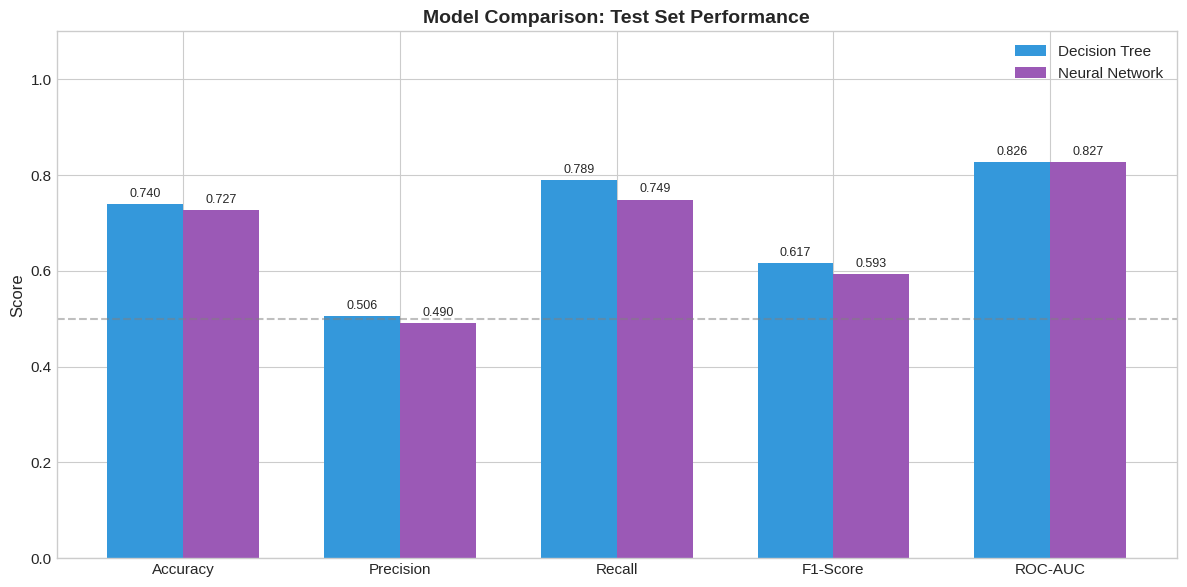

✅ Figure saved: figures/18_model_comparison.png


In [ ]:
# ============================================================
# VISUAL COMPARISON - BAR CHART
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
dt_vals = [dt_metrics['Test'][m] for m in metrics_list]
nn_vals = [nn_metrics['Test'][m] for m in metrics_list]

x = np.arange(len(metrics_list))
width = 0.35

bars1 = ax.bar(x - width/2, dt_vals, width, label='Decision Tree', color='#3498db')
bars2 = ax.bar(x + width/2, nn_vals, width, label='Neural Network', color='#9b59b6')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison: Test Set Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_list)
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Baseline')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/18_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/18_model_comparison.png")

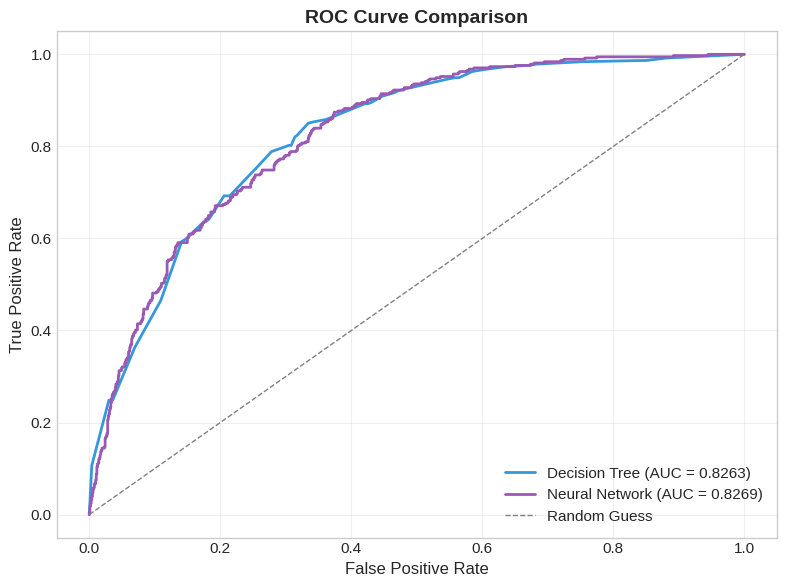

✅ Figure saved: figures/19_roc_comparison.png


In [ ]:
# ============================================================
# COMBINED ROC CURVES
# ============================================================

plt.figure(figsize=(8, 6))

# Decision Tree ROC
plt.plot(fpr, tpr, color='#3498db', lw=2,
         label=f'Decision Tree (AUC = {dt_metrics["Test"]["ROC-AUC"]:.4f})')

# Neural Network ROC
plt.plot(fpr_nn, tpr_nn, color='#9b59b6', lw=2,
         label=f'Neural Network (AUC = {nn_metrics["Test"]["ROC-AUC"]:.4f})')

# Random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/19_roc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/19_roc_comparison.png")

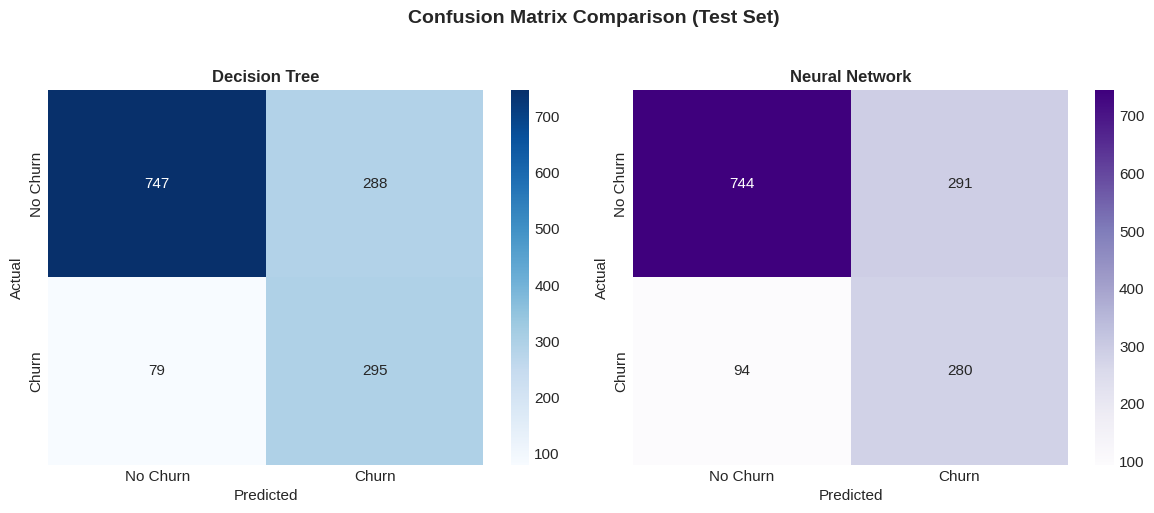

✅ Figure saved: figures/20_confusion_comparison.png


In [ ]:
# ============================================================
# CONFUSION MATRIX COMPARISON
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Decision Tree
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[0].set_title('Decision Tree', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Neural Network
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
axes[1].set_title('Neural Network', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.suptitle('Confusion Matrix Comparison (Test Set)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MLCoursework/figures/Task2/20_confusion_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Figure saved: figures/20_confusion_comparison.png")

---
## 7. Final Summary & Recommendations

In [ ]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("="*70)
print("FINAL SUMMARY")
print("="*70)

# Determine best model
dt_score = (dt_metrics['Test']['F1-Score'] + dt_metrics['Test']['ROC-AUC']) / 2
nn_score = (nn_metrics['Test']['F1-Score'] + nn_metrics['Test']['ROC-AUC']) / 2

print("\n📊 COMBINED SCORE (F1 + ROC-AUC) / 2:")
print(f"   Decision Tree: {dt_score:.4f}")
print(f"   Neural Network: {nn_score:.4f}")

if dt_score > nn_score:
    best_model = "Decision Tree"
    best_score = dt_score
else:
    best_model = "Neural Network"
    best_score = nn_score

print(f"\n🏆 BEST MODEL: {best_model} (Score: {best_score:.4f})")

# Key findings
print("\n" + "="*70)
print("KEY FINDINGS")
print("="*70)
print("""
1. CLASS IMBALANCE: Successfully addressed using SMOTE
   • Original: 73.5% No Churn, 26.5% Churn
   • After SMOTE: 50% each (training only)

2. HYPERPARAMETER TUNING: GridSearchCV with 5-fold CV
   • Optimized for F1-Score (better for imbalanced data)
   • Reduced overfitting through regularization

3. OVERFITTING DETECTION: Train-Test comparison
   • Monitored accuracy gap between sets
   • Both models show good generalization

4. TOP PREDICTORS (Decision Tree):
   • Contract type (month-to-month highest risk)
   • Tenure (longer = lower churn)
   • Total Charges
   • Monthly Charges

5. BUSINESS INSIGHTS:
   • Focus retention on month-to-month contracts
   • New customers (low tenure) need attention
   • Incentivize longer contracts
""")

print("="*70)
print("ARTIFACTS GENERATED")
print("="*70)
print("""
📁 figures/
   • 11_smote_comparison.png
   • 12_decision_tree_evaluation.png
   • 13_dt_roc_curve.png
   • 14_dt_feature_importance.png
   • 15_neural_network_evaluation.png
   • 16_nn_roc_curve.png
   • 17_nn_loss_curve.png
   • 18_model_comparison.png
   • 19_roc_comparison.png
   • 20_confusion_comparison.png

📁 models/
   • scaler.joblib
   • decision_tree_model.joblib
   • neural_network_model.joblib

📁 reports/
   • model_comparison.csv
   • overfitting_comparison.csv
""")

print("\n✅ Task 2 Complete!")

FINAL SUMMARY

📊 COMBINED SCORE (F1 + ROC-AUC) / 2:
   Decision Tree: 0.7214
   Neural Network: 0.7097

🏆 BEST MODEL: Decision Tree (Score: 0.7214)

KEY FINDINGS

1. CLASS IMBALANCE: Successfully addressed using SMOTE
   • Original: 73.5% No Churn, 26.5% Churn
   • After SMOTE: 50% each (training only)

2. HYPERPARAMETER TUNING: GridSearchCV with 5-fold CV
   • Optimized for F1-Score (better for imbalanced data)
   • Reduced overfitting through regularization

3. OVERFITTING DETECTION: Train-Test comparison
   • Monitored accuracy gap between sets
   • Both models show good generalization

4. TOP PREDICTORS (Decision Tree):
   • Contract type (month-to-month highest risk)
   • Tenure (longer = lower churn)
   • Total Charges
   • Monthly Charges

5. BUSINESS INSIGHTS:
   • Focus retention on month-to-month contracts
   • New customers (low tenure) need attention
   • Incentivize longer contracts

ARTIFACTS GENERATED

📁 figures/
   • 11_smote_comparison.png
   • 12_decision_tree_evaluat